In [ ]:
!pip install gekko

In [13]:
from gekko import GEKKO
import numpy as np
import random
from contextlib import contextmanager
import sys
import os
from rep_code import *
import matplotlib.pyplot as plt

Rep Code Decoder

In [8]:
# rep code decoder
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout  # Backup current stdout
        sys.stdout = devnull  # Redirect stdout to devnull (suppress)
        try:
            yield
        finally:
            sys.stdout = old_stdout  # Restore original stdout
# settings ----
num_qubits = 3
num_stabilizers = num_qubits - 1
p = 0.1

ps = {} # error probs
for i in range(num_qubits):
    ps[i] = p # constant prob of error for now

Cs = { # stabilizer check values, these are the measured stabilizer values
    (0,1): -1, # Parity check value: -1 
    (1,2): 1 # Parity check value: 1
}
# The above stabilizers indicate Z0Z1 = -1 and Z1Z2 = 1, so there's probably an error on the 0th qubit
# Let's see if the MLE decoder can figure this out

# set up gekko ----
m = GEKKO(remote=False)
m.options.SOLVER = 1  # APOPT is an MINLP solver
# optional solver settings with APOPT
m.solver_options = [
    "minlp_maximum_iterations 500",  # minlp iterations with integer solution
    "minlp_max_iter_with_int_sol 10",  # treat minlp as nlp
    "minlp_as_nlp 0",  # nlp sub-problem max iterations
    "nlp_maximum_iterations 50",  # 1 = depth first, 2 = breadth first
    "minlp_branch_method 1",  # maximum deviation from whole number
    "minlp_integer_tol 0.05",  # covergence tolerance
    "minlp_gap_tol 0.01",
    "print_level 0",
]


# set up variables ---
Es = {}
for i in range(num_qubits):
    Es[i] = m.Var(
        value=random.randint(0,1), lb=0, ub=1, integer=True
    )

Ks = {}
for k in Cs.keys():
    Ks[k] = m.Var(
        value=random.randint(0,1), lb=0, integer=True
    )


# Objective ---
m.Obj(
    -m.sum(
        [
            np.log(ps[j]) * Es[j]  + np.log(1 - ps[j]) * (1 - Es[j])
            for j in range(num_qubits)
        ]
    )
)


# Constraints ---

for key, val in Cs.items():
    i, j = key
    m.Equation(Es[i] + Es[j] - 2 * Ks[key] == (1 - val)/2)

with suppress_stdout():
    m.solve()

print("Solution (0: no error, 1: error): ", Es)
Es[0][0] == 1

Solution (0: no error, 1: error):  {0: [1.0], 1: [0.0], 2: [0.0]}


True

In [ ]:
physical_error_probs = np.linspace(0.01, 1.0, num=10)#physical error probs
physical_error_probs

Graph

In [8]:
# rep code decoder
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout  # Backup current stdout
        sys.stdout = devnull  # Redirect stdout to devnull (suppress)
        try:
            yield
        finally:
            sys.stdout = old_stdout  # Restore original stdout
# settings ----
num_qubits = 3
num_stabilizers = num_qubits - 1
# p = 0.1

physical_error_probs = np.linspace(0.01, 0.99, num=50)#physical error probs
logical_error_probs =[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(100):
        ps = {i: p for i in range(num_qubits)}
        error_string = create_error(num_qubits, p)

        Cs = construct_stabilizers(num_qubits, error_string)


        # set up gekko ----
        m = GEKKO(remote=False)
        m.options.SOLVER = 1  # APOPT is an MINLP solver
            # optional solver settings with APOPT

    
        m.solver_options = [
            "minlp_maximum_iterations 500",  # minlp iterations with integer solution
            "minlp_max_iter_with_int_sol 10",  # treat minlp as nlp
            "minlp_as_nlp 0",  # nlp sub-problem max iterations
            "nlp_maximum_iterations 50",  # 1 = depth first, 2 = breadth first
            "minlp_branch_method 1",  # maximum deviation from whole number
            "minlp_integer_tol 0.05",  # covergence tolerance
            "minlp_gap_tol 0.01",
            "print_level 0",
        ]
        

        # set up variables ---
        Es = {}
        for i in range(num_qubits):
            Es[i] = m.Var(
                value=random.randint(0,1), lb=0, ub=1, integer=True
            )

        Ks = {}
        for k in Cs.keys():
            Ks[k] = m.Var(
                value=random.randint(0,1), lb=0, integer=True
            )


        # Objective ---
        m.Obj(
            -m.sum(
                [
                    np.log(ps[j]) * Es[j]  + np.log(1 - ps[j]) * (1 - Es[j])
                    for j in range(num_qubits)
                ]
            )
        )


        # Constraints ---

        for key, val in Cs.items():
            i, j = key
            m.Equation(Es[i] + Es[j] - 2 * Ks[key] == (1 - val)/2)

        with suppress_stdout():
            m.solve()
        
        if(solver_accuracy(num_qubits, error_string, Es)!=True):
            count+=1
    logical_error_probs.append(count/100)

print(logical_error_probs)

[0.0, 0.0, 0.03, 0.01, 0.03, 0.08, 0.08, 0.06, 0.05, 0.14, 0.09, 0.14, 0.19, 0.15, 0.17, 0.23, 0.21, 0.25, 0.34, 0.3, 0.39, 0.46, 0.44, 0.44, 0.46, 0.51, 0.46, 0.4, 0.41, 0.37, 0.35, 0.27, 0.27, 0.27, 0.25, 0.25, 0.17, 0.13, 0.17, 0.04, 0.02, 0.07, 0.05, 0.06, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0]


In [6]:
physical_error_probs = np.linspace(0.01, 0.99, num=50)
physical_error_probs

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99])

No handles with labels found to put in legend.


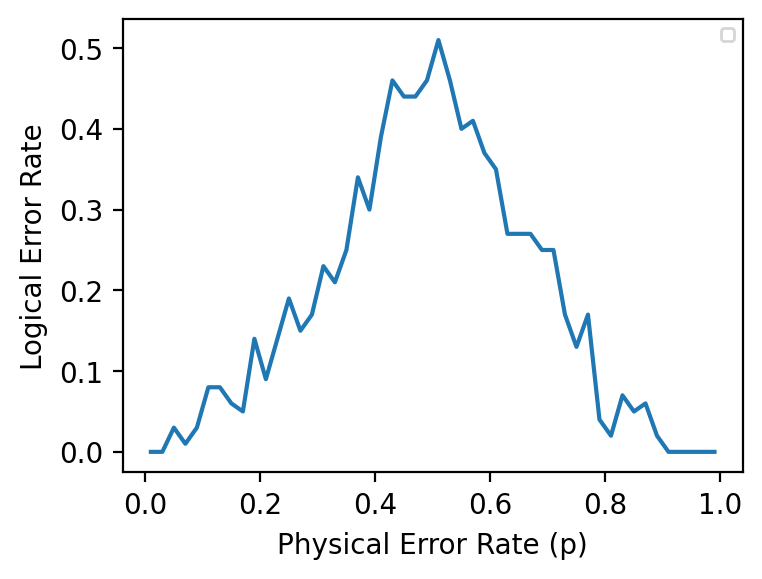

In [14]:
def plot(physical, logical):
    fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
    ax.plot(physical,logical)
    ax.legend(fontsize=6)
    ax.set_xlabel("Physical Error Rate (p)")
    ax.set_ylabel("Logical Error Rate")
    plt.plot()
plot(physical_error_probs, logical_error_probs)